# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
import joblib

(A, terms, snippets) = joblib.load("21cenario1-tweets-tfidf.pkl")

print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 1437323 X 25458 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [2]:
kmin, kmax = 5, 20

Apply NMF for each of these values:

In [3]:
from sklearn import decomposition

topic_models = []

# try each value of k
for k in [5,10,15,20]: #range(kmin, kmax + 1):
    print("Applying NMF for k=%d ..." % k)
    # run NMF
    model = decomposition.NMF(init="nndsvd", n_components=k)
    W = model.fit_transform(A)
    H = model.components_
    # store for later
    topic_models.append((k, W, H))

Applying NMF for k=5 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [4]:
import os.path

raw_documents = []

with open(os.path.join("cenario1_8M2021_tweets_es.txt"), "r") as fin:
    for line in fin.readlines():
        raw_documents.append(line.strip().lower())

print("Read %d raw text documents" % len(raw_documents))

Read 1437323 raw text documents


Read the custom stopword list:

In [5]:
custom_stop_words = []

with open("spanish.txt", "r") as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 313 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [6]:
import re


class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok)
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [7]:
import gensim

In [8]:


docgen = TokenGenerator(raw_documents, custom_stop_words)

# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [9]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 25597 terms


Save for later use, so that we do not need to rebuild it:

In [10]:
w2v_model.save("21cenario1_w2v-model.bin")

In [11]:
# To re-load this model, run
# w2v_model = gensim.models.Word2Vec.load("cenario1_w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [12]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [13]:
import numpy as np


def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    
    return top_terms

Now process each of the models for different values of *k*:

In [14]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.2210
K=10: Coherence=0.2257
K=15: Coherence=0.2301
K=20: Coherence=0.2313


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

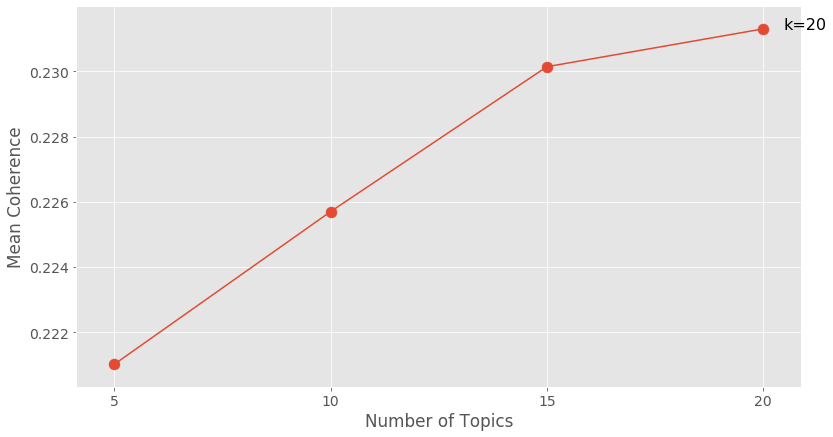

In [16]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

# 5

In [17]:
k = 5 # best_k

# get the model that we generated earlier.
W = topic_models[0][1]
H = topic_models[0][2]

In [18]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, dia, falte, ninguna, mujer
Topic 02: miedo, crecieron, sembraron, alas, libres
Topic 03: buen, recordar, video, hoy, dia
Topic 04: todas, mujeres, lucha, hoy, siempre
Topic 05: escobedo, marisela, hija, palacio, feminicidio


In [19]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, dia, falte, ninguna, mujer, ser, internacional, nadie, podamos, dejen
Topic 02: miedo, crecieron, sembraron, alas, libres, vivir, cancion, vivas, exagerado, ser
Topic 03: buen, recordar, video, hoy, dia, creo, momento, hace, lucha, mujer
Topic 04: todas, mujeres, lucha, hoy, siempre, mundo, igualdad, juntas, derechos, feminismo
Topic 05: escobedo, marisela, hija, palacio, feminicidio, frente, olvidemos, enfrento, impune, lucho


In [20]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, dia, falte, ninguna, mujer, ser, internacional, nadie, podamos, dejen, primer, logro, legal, aborto, matarnos
Topic 02: miedo, crecieron, sembraron, alas, libres, vivir, cancion, vivas, exagerado, ser, casa, corten, razon, juntas, calma
Topic 03: buen, recordar, video, hoy, dia, creo, momento, hace, lucha, mujer, manifestantes, dias, ano, zocalo, conmemora
Topic 04: todas, mujeres, lucha, hoy, siempre, mundo, igualdad, juntas, derechos, feminismo, violencia, asi, mujer, faltan, reconocimiento
Topic 05: escobedo, marisela, hija, palacio, feminicidio, frente, olvidemos, enfrento, impune, lucho, asesinada, feminicida, narcos, gobernador, quedo


In [21]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, dia, falte, ninguna, mujer, ser, internacional, nadie, podamos, dejen, primer, logro, legal, aborto, matarnos, salir, tranquilas, haga, marzo, trabajadora
Topic 02: miedo, crecieron, sembraron, alas, libres, vivir, cancion, vivas, exagerado, ser, casa, corten, razon, juntas, calma, callen, existe, quitan, tiemble, cielos
Topic 03: buen, recordar, video, hoy, dia, creo, momento, hace, lucha, mujer, manifestantes, dias, ano, zocalo, conmemora, difunden, indicaciones, internacional, dando, protestas
Topic 04: todas, mujeres, lucha, hoy, siempre, mundo, igualdad, juntas, derechos, feminismo, violencia, asi, mujer, faltan, reconocimiento, gracias, vos, cada, feminista, cambiando
Topic 05: escobedo, marisela, hija, palacio, feminicidio, frente, olvidemos, enfrento, impune, lucho, asesinada, feminicida, narcos, gobernador, quedo, red, nunca, hizo, gobierno, nacional


# 10

In [22]:
k = 10 # best_k

# get the model that we generated earlier.
W = topic_models[1][1]
H = topic_models[1][2]

In [23]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, dia, falte, ninguna, ser
Topic 02: miedo, crecieron, sembraron, alas, libres
Topic 03: buen, recordar, video, hoy, dia
Topic 04: mujer, dia, internacional, marzo, ser
Topic 05: escobedo, marisela, hija, olvidemos, lucho
Topic 06: todas, siempre, juntas, faltan, vos
Topic 07: oirlo, cansas, vivirlo, escucharlo, formosenas
Topic 08: nacional, palacio, vallas, fotos, victimas
Topic 09: mujeres, lucha, hoy, igualdad, derechos
Topic 10: mundo, imagen, vuelta, dara, mira


In [24]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, dia, falte, ninguna, ser, podamos, nadie, dejen, logro, legal
Topic 02: miedo, crecieron, sembraron, alas, libres, vivir, cancion, vivas, juntas, exagerado
Topic 03: buen, recordar, video, hoy, dia, creo, momento, hace, ano, manifestantes
Topic 04: mujer, dia, internacional, marzo, ser, trabajadora, felicidades, cada, conmemoracion, muchas
Topic 05: escobedo, marisela, hija, olvidemos, lucho, enfrento, impune, asesinada, narcos, feminicida
Topic 06: todas, siempre, juntas, faltan, vos, aquellas, luchamos, mama, partio, corazon
Topic 07: oirlo, cansas, vivirlo, escucharlo, formosenas, admirable, siempre, exige, cansado, coraje
Topic 08: nacional, palacio, vallas, fotos, victimas, nombres, frente, pintaron, imagenes, lean
Topic 09: mujeres, lucha, hoy, igualdad, derechos, violencia, feminista, asi, feminismo, hombres
Topic 10: mundo, imagen, vuelta, dara, mira, cambiando, reconocimiento, sirvieron, mejor, pinche


In [25]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, dia, falte, ninguna, ser, podamos, nadie, dejen, logro, legal, aborto, primer, matarnos, salir, haga
Topic 02: miedo, crecieron, sembraron, alas, libres, vivir, cancion, vivas, juntas, exagerado, casa, corten, razon, calma, ser
Topic 03: buen, recordar, video, hoy, dia, creo, momento, hace, ano, manifestantes, difunden, indicaciones, dando, siempre, zocalo
Topic 04: mujer, dia, internacional, marzo, ser, trabajadora, felicidades, cada, conmemoracion, muchas, feliz, ilumina, marco, hoy, mejor
Topic 05: escobedo, marisela, hija, olvidemos, lucho, enfrento, impune, asesinada, narcos, feminicida, gobernador, quedo, red, nunca, hizo
Topic 06: todas, siempre, juntas, faltan, vos, aquellas, luchamos, mama, partio, corazon, memoria, hoy, feminismo, felicidades, solas
Topic 07: oirlo, cansas, vivirlo, escucharlo, formosenas, admirable, siempre, exige, cansado, coraje, toca, argentina, caminar, cansados, vivir
Topic 08: nacional, palacio, vallas, fotos, victimas, nombres, frente

In [26]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, dia, falte, ninguna, ser, podamos, nadie, dejen, logro, legal, aborto, primer, matarnos, salir, haga, aquellas, tranquilas, calle, decime, paren
Topic 02: miedo, crecieron, sembraron, alas, libres, vivir, cancion, vivas, juntas, exagerado, casa, corten, razon, calma, ser, quitan, callen, existe, tiemble, cielos
Topic 03: buen, recordar, video, hoy, dia, creo, momento, hace, ano, manifestantes, difunden, indicaciones, dando, siempre, zocalo, aquellas, dias, protestas, conmemora, celebramos
Topic 04: mujer, dia, internacional, marzo, ser, trabajadora, felicidades, cada, conmemoracion, muchas, feliz, ilumina, marco, hoy, mejor, morado, gana, conmemorar, celebrar, dias
Topic 05: escobedo, marisela, hija, olvidemos, lucho, enfrento, impune, asesinada, narcos, feminicida, gobernador, quedo, red, nunca, hizo, feminicidio, gobierno, frente, palacio, criando
Topic 06: todas, siempre, juntas, faltan, vos, aquellas, luchamos, mama, partio, corazon, memoria, hoy, feminismo, felici

# 15

In [27]:
k = 15 # best_k

# get the model that we generated earlier.
W = topic_models[2][1]
H = topic_models[2][2]

In [28]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mujer, dia, internacional, marzo, trabajadora
Topic 02: miedo, crecieron, sembraron, alas, vivir
Topic 03: buen, recordar, video, hoy, dia
Topic 04: mujeres, violencia, derechos, pais, luchando
Topic 05: escobedo, marisela, hija, olvidemos, enfrento
Topic 06: todas, vos, faltan, luchamos, mama
Topic 07: oirlo, cansas, vivirlo, escucharlo, formosenas
Topic 08: nacional, palacio, vallas, fotos, victimas
Topic 09: cambiando, mundo, reconocimiento, mujeres, queremos
Topic 10: imagen, vuelta, dara, mira, mundo
Topic 11: foto, ano, mucha, redes, cabreadisimo
Topic 12: asi, metro, empezo, termino, hidalgo
Topic 13: hoy, lucha, igualdad, gracias, dias
Topic 14: feliz, dia, falte, ninguna, ser
Topic 15: siempre, juntas, libres, fuertes, miedo


In [29]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mujer, dia, internacional, marzo, trabajadora, ser, felicidades, conmemoracion, cada, feliz
Topic 02: miedo, crecieron, sembraron, alas, vivir, cancion, libres, exagerado, vivas, casa
Topic 03: buen, recordar, video, hoy, dia, creo, momento, manifestantes, indicaciones, difunden
Topic 04: mujeres, violencia, derechos, pais, luchando, mexico, hombres, seguras, igualdad, historia
Topic 05: escobedo, marisela, hija, olvidemos, enfrento, lucho, impune, asesinada, narcos, feminicida
Topic 06: todas, vos, faltan, luchamos, mama, partio, corazon, memoria, aquellas, juntas
Topic 07: oirlo, cansas, vivirlo, escucharlo, formosenas, admirable, exige, cansado, coraje, toca
Topic 08: nacional, palacio, vallas, fotos, victimas, nombres, pintaron, imagenes, lean, todxs
Topic 09: cambiando, mundo, reconocimiento, mujeres, queremos, iguales, libres, mejor, humanamente, socialmente
Topic 10: imagen, vuelta, dara, mira, mundo, sirvieron, mejor, pinche, dicho, foto
Topic 11: foto, ano, mucha, re

In [30]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mujer, dia, internacional, marzo, trabajadora, ser, felicidades, conmemoracion, cada, feliz, muchas, ilumina, marco, morado, mejor
Topic 02: miedo, crecieron, sembraron, alas, vivir, cancion, libres, exagerado, vivas, casa, corten, razon, calma, quitan, callen
Topic 03: buen, recordar, video, hoy, dia, creo, momento, manifestantes, indicaciones, difunden, zocalo, dando, protestas, hombre, estremece
Topic 04: mujeres, violencia, derechos, pais, luchando, mexico, hombres, seguras, igualdad, historia, presidente, feminista, mexicanas, genero, policias
Topic 05: escobedo, marisela, hija, olvidemos, enfrento, lucho, impune, asesinada, narcos, feminicida, gobernador, quedo, red, nunca, hizo
Topic 06: todas, vos, faltan, luchamos, mama, partio, corazon, memoria, aquellas, juntas, feminismo, felicidades, solas, anduvieramos, vinimos
Topic 07: oirlo, cansas, vivirlo, escucharlo, formosenas, admirable, exige, cansado, coraje, toca, argentina, caminar, cansados, vivir, lado
Topic 08: na

In [31]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mujer, dia, internacional, marzo, trabajadora, ser, felicidades, conmemoracion, cada, feliz, muchas, ilumina, marco, morado, mejor, conmemorar, especial, celebrar, gana, vida
Topic 02: miedo, crecieron, sembraron, alas, vivir, cancion, libres, exagerado, vivas, casa, corten, razon, calma, quitan, callen, existe, ser, tiemble, cielos, judiciales
Topic 03: buen, recordar, video, hoy, dia, creo, momento, manifestantes, indicaciones, difunden, zocalo, dando, protestas, hombre, estremece, capitulo, rompieron, incluye, piedras, identificaron
Topic 04: mujeres, violencia, derechos, pais, luchando, mexico, hombres, seguras, igualdad, historia, presidente, feminista, mexicanas, genero, policias, feminismo, vida, marcha, gobierno, grito
Topic 05: escobedo, marisela, hija, olvidemos, enfrento, lucho, impune, asesinada, narcos, feminicida, gobernador, quedo, red, nunca, hizo, feminicidio, gobierno, frente, palacio, criando
Topic 06: todas, vos, faltan, luchamos, mama, partio, corazon, me

# 20

In [32]:
k = 20 # best_k

# get the model that we generated earlier.
W = topic_models[3][1]
H = topic_models[3][2]

Display the topic descriptors for this model:

In [33]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mujer, dia, internacional, marzo, ser
Topic 02: miedo, crecieron, sembraron, alas, vivir
Topic 03: buen, recordar, video, dia, hoy
Topic 04: mujeres, violencia, derechos, luchando, pais
Topic 05: escobedo, marisela, hija, olvidemos, enfrento
Topic 06: todas, vos, faltan, luchamos, mama
Topic 07: oirlo, cansas, vivirlo, escucharlo, formosenas
Topic 08: nacional, palacio, ojos, gas, lacrimogeno
Topic 09: cambiando, mundo, reconocimiento, mujeres, iguales
Topic 10: imagen, vuelta, dara, mira, mundo
Topic 11: foto, ano, mucha, redes, cabreadisimo
Topic 12: asi, empezo, termino, hombres, anduvieramos
Topic 13: hoy, lucha, gracias, dias, hace
Topic 14: feliz, dia, legal, aborto, logro
Topic 15: siempre, juntas, libres, miedo, fuertes
Topic 16: metro, hidalgo, leslie, perez, marcha
Topic 17: vallas, fotos, victimas, nombres, imagenes
Topic 18: feminismo, igualdad, recordad, queremos, primero
Topic 19: falte, ninguna, ser, dia, feliz
Topic 20: presidente, andres, obrador, manuel, lop

In [34]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mujer, dia, internacional, marzo, ser, trabajadora, felicidades, conmemoracion, cada, muchas
Topic 02: miedo, crecieron, sembraron, alas, vivir, cancion, libres, exagerado, vivas, casa
Topic 03: buen, recordar, video, dia, hoy, creo, momento, manifestantes, indicaciones, difunden
Topic 04: mujeres, violencia, derechos, luchando, pais, hombres, mexico, seguras, igualdad, feminista
Topic 05: escobedo, marisela, hija, olvidemos, enfrento, lucho, impune, asesinada, narcos, feminicida
Topic 06: todas, vos, faltan, luchamos, mama, partio, corazon, memoria, aquellas, juntas
Topic 07: oirlo, cansas, vivirlo, escucharlo, formosenas, admirable, exige, cansado, coraje, toca
Topic 08: nacional, palacio, ojos, gas, lacrimogeno, florecitas, metieron, llorando, muchas, arrojado
Topic 09: cambiando, mundo, reconocimiento, mujeres, iguales, queremos, libres, mejor, humanamente, socialmente
Topic 10: imagen, vuelta, dara, mira, mundo, sirvieron, mejor, pinche, dicho, foto
Topic 11: foto, ano, 

In [35]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mujer, dia, internacional, marzo, ser, trabajadora, felicidades, conmemoracion, cada, muchas, ilumina, marco, morado, mejor, conmemorar
Topic 02: miedo, crecieron, sembraron, alas, vivir, cancion, libres, exagerado, vivas, casa, corten, razon, calma, quitan, callen
Topic 03: buen, recordar, video, dia, hoy, creo, momento, manifestantes, indicaciones, difunden, dando, zocalo, protestas, hombre, estremece
Topic 04: mujeres, violencia, derechos, luchando, pais, hombres, mexico, seguras, igualdad, feminista, historia, genero, mexicanas, vida, policias
Topic 05: escobedo, marisela, hija, olvidemos, enfrento, lucho, impune, asesinada, narcos, feminicida, gobernador, quedo, red, nunca, hizo
Topic 06: todas, vos, faltan, luchamos, mama, partio, corazon, memoria, aquellas, juntas, felicidades, companeras, solas, anduvieramos, vinimos
Topic 07: oirlo, cansas, vivirlo, escucharlo, formosenas, admirable, exige, cansado, coraje, toca, argentina, caminar, cansados, vivir, lado
Topic 08: na

In [36]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mujer, dia, internacional, marzo, ser, trabajadora, felicidades, conmemoracion, cada, muchas, ilumina, marco, morado, mejor, conmemorar, celebrar, especial, vamos, gana, vida
Topic 02: miedo, crecieron, sembraron, alas, vivir, cancion, libres, exagerado, vivas, casa, corten, razon, calma, quitan, callen, existe, tiemble, cielos, judiciales, volver
Topic 03: buen, recordar, video, dia, hoy, creo, momento, manifestantes, indicaciones, difunden, dando, zocalo, protestas, hombre, estremece, capitulo, rompieron, muestra, piedras, autoridades
Topic 04: mujeres, violencia, derechos, luchando, pais, hombres, mexico, seguras, igualdad, feminista, historia, genero, mexicanas, vida, policias, ninas, grito, chingonas, trabajo, marcha
Topic 05: escobedo, marisela, hija, olvidemos, enfrento, lucho, impune, asesinada, narcos, feminicida, gobernador, quedo, red, nunca, hizo, feminicidio, gobierno, frente, palacio, criando
Topic 06: todas, vos, faltan, luchamos, mama, partio, corazon, memoria